<a href="https://colab.research.google.com/github/charleslow-cmu/bva-capstone/blob/master/citation_analysis/v3_extract_vljs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BVA Decision Document: Citation Analysis

Author: Hongyi Zhang

Extract citations for all documents and analyze their trends.

Update (04/09/2020): Re-extracted citations for all documents (better match, both case and statutes), Successful extraction of VLJ names

Update (03/28/2020): Focus on appeal eligible cases

Original: Preliminary plots and analysis

## Setup

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
# install Google cloud storage FUSE to mount GCP bucket on colab
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse
!pip3 install fuzzywuzzy
!mkdir /bva-data
!gcsfuse bva-prediction-data /bva-data  # caution on write and/or delete

In [33]:
import re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import locale
import time
from pandas.plotting import register_matplotlib_converters
from fuzzywuzzy import process
register_matplotlib_converters()
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

'en_US.UTF-8'

## Connect to MongoDB

Database credentials are in `db_config.py` stored in the GCP bucket to ensure security.

In [0]:
import pymongo
import os
os.chdir('/bva-data/')
from db_config import *

# connect to mongo database
db = pymongo.MongoClient(host=DB_HOST, port=DB_PORT)[DB_DATABASE]
db.authenticate(DB_USER, DB_PASSWORD)

True

In [0]:
# example document structure
db.documents.find_one()

In [0]:
# total number of documents
db.documents.estimated_document_count()

1024074

In [0]:
# example metadata structure
db.appeals_meta.find_one()

{'_id': ObjectId('5e7e3c1afaa88ea8a97be370'),
 'appeal_id': '1000001',
 'appealed_CAVC': '0',
 'cvdisp': '',
 'cvdocket': '',
 'imgadtm': '2001-09-17',
 'isscode': '12',
 'issdc': '3',
 'isslev2': '9411',
 'isslev3': 'NA',
 'issprog': '2',
 'issseq': '1',
 'issue_count': '1',
 'issue_id': '1000001-1-1',
 'tiread2': '0122817'}

In [0]:
# example scraped metadata structure
db.appeals_meta_wscraped.find_one()

{'_id': ObjectId('5e88980c1c02e644933a2a5d'),
 'appeal_id': '1000001',
 'appealed_CAVC': '0',
 'appealed_cavc_appeal_level': '0',
 'cvdisp': '',
 'cvdocket': '',
 'cvjoint': '0',
 'imgadtm': '2001-09-17',
 'isscode': '12',
 'issdc': '3',
 'isslev2': '9411',
 'isslev3': 'NA',
 'issprog': '2',
 'issseq': '1',
 'issue_count': '1',
 'issue_id': '1000001-1-1',
 'jmr_appeal_level': '0',
 'tiread2': '0122817'}

In [0]:
# filter single issue cases
single_issue_ids = pd.DataFrame(list(db.appeals_meta.find(
    {"issue_count": "1"},       # find single issue cases
    {"_id": 0, "tiread2": 1}    # we only want their IDs
)))
single_issue_ids

,tiread2
0,122817
1,123419
2,824198
3,331171
4,101964
...,...
386163,31043
386164,408240
386165,102745
386166,18154424


## Extract citations for all BVA decision documents

Citation extraction code: credit to Mark Krass.

No need to run this part again since I have already written the data to the database `db.citations`.

NOTE: the citation extraction code is updated to match citations better, plus incorporated Charles' code to add type (case/statutory) and position in text.

CAVEAT: sorry just thought of it, but the position field refers to the indices in the cleaned text (after removing \ufffd, \r\n, etc.), so it might not be directly useful for extracting original citation text unless using the same `clean_text` function below in `extract_citations`.

In [0]:
# Build a pattern to extract case and statute citations
# Author: Mark Krass
# NOTE: this part is updated!

case_patt = re.compile('(See\s|See,\se\.g\.,\s|See\salso|)([DeMcO\'Mac]*[A-Z][a-z]+\s[A-Z]?[a-z]*\s?v\.\s[A-Z][a-z]+)([,\s]+|)(\d{1,4})\s(F.2d|F.3d|F.|Vet. App.|U.S.|F. Supp.|F.Supp.|F. Supp. 2d|F. Supp. 3d|F.Supp.2d|F.Supp.3d|F. Supp. 2d.|F. Supp. 3d.)(\s|\sat\s)(\d{1,4})[,\s]*(\d{1,4}[,\-\s]*\d*|)[,\-\s]*(\d*|)(\s?\([A-Za-z\.\s]*\d{4}\)|)')
statute_patt = re.compile('([0-9]{1,4}\s)(C.F.R.|U.S.C.A.|U.S.C.|C. F. R.|U. S. C.| U. S. C. A.)\s[\\xa7]*\s*(\d{1,4}[\.,\s]*\d{1,4}[\(\)A-Za-z\d]*)([,\s\d]*)(\([A-Za-z\.\s]*\d{4}\)|)')

def citeparse(components): 
    """Given a case citation, label its constituent components"""
    components = [item.strip() for item in components]
    signal, caption, _, volume, reporter, s, startpage, pin1, pin2, year = components
    out = {
        'signal': signal,           # this is an indication of how the authority is being used
        'caption': caption,         # title of the cited case
        'volume': volume,           # volume of the book where the case is reported
        'reporter': reporter,       # case reporter
        'startpage': startpage,     # case start page in the reporter
        'pincites': [pin1, pin2],   # specific reference in the reporter
        'yr': year.strip('()'),
        'case': volume + ' ' + reporter + ' ' + startpage
    }
    return out

def statparse(components): 
    components = [item.strip() for item in components]
    vol, code, s1, s2, year = components
    # Turn the sections into a list of individual section numbers
    if s2 != '':
        ss = ', '.join([s1,s2]).split(', ')
    elif s2 == '':
        ss = s1.split(', ')
    ss = [x for x in ss if x is not '']
    # create a dict and count refs to each statute section
    out = {
        'statutes': [' '.join([vol, code, s]) for s in ss],
        'volume': vol,
        'code': code,
        'year': year.strip('()'),
        'sections': ss
    }
    return out

def extract_citations(document):
    """
    New function to streamline the extraction process with new fields
    Main updates include:
        1. handle \r\n more carefully
        2. add citation type (case/statute) and position in text
        3. strip commas in case caption and brackets in years
    Adapted from Charles' code
    """
    def clean_text(text):
        return ' '.join(text.replace('\ufffd', '').replace('\r\n', ' ').split())

    def find_citation_by_pattern(text, citation_type, pattern, parser):
        return [{
            "position": m.span(),
            "type": citation_type,
            **parser(m.groups())
        } for m in re.finditer(pattern, text)]  

    # Find cases, then statutes
    cleaned_text = clean_text(document.pop('txt'))
    cases = find_citation_by_pattern(cleaned_text, "case", case_patt, citeparse)
    statutes = find_citation_by_pattern(cleaned_text, "statute", statute_patt, statparse)

    # Sort citations by start position
    citations = sorted(cases + statutes, key=lambda k: k['position'][0]) 
    return {"bva_id": document['bva_id'], "citations": citations}

In [0]:
# test citation extraction
document = db.documents.find_one()
extract_citations(document)

{'bva_id': '0410326',
 'citations': [{'code': 'U.S.C.A.',
   'position': (3356, 3373),
   'sections': ['5102'],
   'statutes': ['38 U.S.C.A. 5102'],
   'type': 'statute',
   'volume': '38',
   'year': ''},
  {'code': 'C.F.R.',
   'position': (3395, 3420),
   'sections': ['3.159(b)'],
   'statutes': ['38 C.F.R. 3.159(b)'],
   'type': 'statute',
   'volume': '38',
   'year': '2003'},
  {'caption': 'Quartuccio v. Principi',
   'case': '16 Vet. App. 183',
   'pincites': ['', ''],
   'position': (3422, 3473),
   'reporter': 'Vet. App.',
   'signal': 'See',
   'startpage': '183',
   'type': 'case',
   'volume': '16',
   'yr': '2002'},
  {'code': 'U.S.C.',
   'position': (3506, 3525),
   'sections': ['5103(a)', ','],
   'statutes': ['38 U.S.C. 5103(a)', '38 U.S.C. ,'],
   'type': 'statute',
   'volume': '38',
   'year': ''},
  {'code': 'C.F.R.',
   'position': (3545, 3562),
   'sections': ['3.159', ','],
   'statutes': ['38 C.F.R. 3.159', '38 C.F.R. ,'],
   'type': 'statute',
   'volume': '38

In [0]:
# extract citations for every document
# this can take ~80 minutes
citation_list = []
all_documents = db.documents.find({}, {"_id": 0, "bva_id": 1, "txt": 1})

cnt = 0
for document in all_documents:
    citation_list.append(extract_citations(document))
    cnt += 1
    if cnt % 1000 == 0:
        print("Finished {} documents".format(cnt))
    if cnt % 100000 == 0:
        db.citations.insert_many(citation_list)
        citation_list.clear()

db.citations.insert_many(citation_list)

In [0]:
# create an index on the collection
db.citations.create_index("bva_id")

'bva_id_1'

## Extract VLJ names from documents

Code for extracting VLJ names: credit to Mark Krass

The `judge_list.csv` file can be downloaded from the `regex files` folder in the shared Google Drive.

In [22]:
# Import a dataset of the VLJs copied from the VA's 2010-2016 annual reports
judges = pd.read_csv("judge_list.csv")

# Now create a little utility function to grab the first initials and last name of the judge
def get_shortname(judgename):
    """
    Given an unedited judge name (e.g., "Wayne M. Braeuer, Jr.") return a shortened version
    of the name with first initials and last name ("W. M. Braeuer"). This format is closer
    to the style used in BVA decisions and will facilitate matching.
    """
    
    parts = [part.replace(',','') for part in judgename.split(' ')] # strip internal commas
    # First split: if the judge has a middle initial ("M."), grab the first two initials
    if len(parts[1]) == 2:
        initials = parts[0][0] + ". " + parts[1]
        # If they have a suffix. . . 
        if len(parts) > 3:
            if parts[3] in ["Jr.", "Sr.", "II", "III", "IV", "V"]:
                # Discard the suffix
                shortname = initials + " " + parts[2]
            else:
                # If it's a double last name keep it
                shortname = initials + " " + parts[2] + " " + parts[3]
        else: # If no suffix then just take the last name
            shortname = initials + " " + parts[2]
    else:
        initials = parts[0][0] + ". "
        if len(parts) > 2: # if no middle initial then suffix would be in third position
            if parts[2] in ["Jr.", "Sr.", "II", "III", "IV", "V"]:
                shortname = initials + " " + parts[1]
            else:
                shortname = initials + " " + parts[1] + " " + parts[2]
        else:
            shortname = initials + " " + parts[1]
    return shortname

# Now use this utility function to clean our ground truth list of judges
judges['shortname'] = [get_shortname(row[1]['judge.name']) for row in judges.iterrows()]
judges.head(2)

,judge.name,title,FY,link,shortname
0,Alan S. Peevy,Veterans' Law Judge,2013,https://www.bva.va.gov/docs/Chairmans_Annual_R...,A. S. Peevy
1,Alan S. Peevy,Veterans' Law Judge,2010,https://www.bva.va.gov/docs/Chairmans_Annual_R...,A. S. Peevy


In [0]:
# Create little utility for taking a tuple of byte text and returning a tuple of unicode text
def convert(bytetuple):
    return tuple([s.decode("utf-8", "ignore") for s in bytetuple])

# Build function to obtain VLJ names
def get_names(string, judge_list=judges, noisy=False):
    """ 
    Given the text of a BVA decision and a data.frame containing an authoritative
    list of BVA judges, return the name of a known judge who authored the decision. 
    
    inputs: @string: the BVA opinion in byte format
            @judge_list: a pd.DataFrame containing the column 'shortname' which is the
                        standardized format for names we created above. 
    outputs: @processed: a list of 5 elements containing the 5 best guesses for who the
                        deciding judge was. 
    
    
    """
    # First, grab the part of the opinion that comes at the end--either beneath the signature line 
    # or after the ORDER
    
    end = re.search(b'(______+.*[\s]+.*)|(ORDER[.\s]+)(.*)', string, re.DOTALL)
    if end: end = end.group()
    else: return [np.NaN for a in np.arange(5)]
    
    # Then extract *all* of the names on the opinion. 
    
    names = re.findall(b'([A-Z]+\.?)( *[A-Z]*\.?)( [A-Z][A-Za-z]+)', end)
    names = [''.join(convert(s)) for s in names]
    names = [name[0] + ". " + name.split(' ')[-1] for name in names]
    
    if noisy: # this is just for dev purposes
        print([process.extract(name, judge_list['shortname'], limit=50) for name in names])
    
    # Now grab all of the names in our authoritative list that have an 
    # acceptably close edit distance to each of the names we got from our file
    # and discard the edit distance score
    
    matched = [process.extractOne(name, judge_list['shortname'], score_cutoff=90) for name in names]
    matched = list(set([name[0] for name in matched if name is not None]))
    
    # Massage the output so we get exactly 5 items
    if len(matched) == 0:
        return [np.NaN for a in np.arange(5)]
    elif len(matched) > 5:
        return matched[:5]
    elif len(matched) < 5 and len(matched) > 0:
        [matched.append(np.NaN) for k in np.arange(5 - len(matched))]
        return matched

In [0]:
def extract_vljs(document):
    """Convert text string to bytes and pass to Mark's extraction"""
    return get_names(document.get('txt').encode())

In [34]:
# test VLJ name extraction
document = db.documents.find_one()
extract_vljs(document)

['A. M. Bryant', nan, nan, nan, nan]

## Four particular citations to consider (TO BE UPDATED)

For each particular citation, we use the `case` field to match cases that contain this citation as it is more robust compared to `caption`.

In [0]:
def find_cases_that_cite(citation):
    """
    Given a citation, find information for all cases that contain that citation
    and also are eligible for appeal.

    @input: a dict conforming to the citation schema above
    @output: a pandas dataframe that contains for each case that has the citation
            id, timestamp (UTC), whether appealed, CAVC disposition (cvdisp),
            issue disposition (issdc), program code (issprog), issue code (isscode)
    """
    df = pd.DataFrame(list(db.citations.aggregate([{
        '$match': {'citations': {'$elemMatch': citation}}
    }, {
        '$lookup': {
            'from': "appeals_meta", 
            'localField': "bva_id", 
            'foreignField': "tiread2",
            'as': "metas"
        }
    }, {
        "$unwind": "$metas"
    }, {
        "$match": { # find appeal eligible cases
            "$expr": {
                "$or" : [ {
                        "$eq": ["$metas.issdc", "4"]
                    }, {
                        "$and": [ {
                            "$eq": ["$metas.issdc", "1"]
                        }, {
                            "$eq": ["$metas.issprog", "2"]
                        }, {
                            "$eq": ["$metas.isscode", "12"]
                        } ]
                    }
                ]
            }
        }
    }, {
        '$project': {
            '_id' : 0,
            'bva_id': 1,
            'timestamp': '$metas.imgadtm',
            'appealed_CAVC': '$metas.appealed_CAVC',
            'cvdisp': '$metas.cvdisp',
            'issdc': '$metas.issdc',
            'issprog': '$metas.issprog',
            'isscode': '$metas.isscode',
        }
    }])))

    if not df.empty:
        df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
        df['appealed_CAVC'] = df['appealed_CAVC'].astype(int)
    return df

In [0]:
# citation 1: Thun v. Peake
# this may take ~20 seconds
thun_v_peake = {
    'case': '22 Vet. App. 111',
}
cases = find_cases_that_cite(thun_v_peake)
cases

,bva_id,timestamp,appealed_CAVC,cvdisp,issdc,issprog,isscode
0,1611988,2016-03-23 00:00:00+00:00,0,,4,2,12
1,1611988,2016-03-23 00:00:00+00:00,0,,4,2,12
2,1611988,2016-03-23 00:00:00+00:00,0,,4,2,12
3,1611988,2016-03-23 00:00:00+00:00,0,,4,2,12
4,1611988,2016-03-23 00:00:00+00:00,0,,4,2,12
...,...,...,...,...,...,...,...
121391,1305878,2013-02-15 00:00:00+00:00,1,8,4,2,12
121392,1319621,2013-06-14 00:00:00+00:00,0,,4,2,12
121393,1319621,2013-06-14 00:00:00+00:00,0,,1,2,12
121394,1321854,2013-07-05 00:00:00+00:00,0,,4,2,12


In [0]:
# describe the appeal destribution
cases.appealed_CAVC.value_counts()

0    101428
1     19968
Name: appealed_CAVC, dtype: int64

Now it's time to incorporate all the citations we would like to investigate into.

- Thun v. Peake, 22 Vet. App. 111 (2008)
    - Case date: April 23, 2008. It became near-ubiquitous in increased rating (IR) claims eventually. Its use then plummeted following a Board training conducted in August 2017, which advised against its use.
- Scott v. McDonald, 789 F.3d 1375 (Fed. Cir. 2015)
    - Case date: June 18, 2015. It slowly started to gain traction with the Board, resulting in me issuing guidance on how to approach it twice. Those guidance emails were dated July 31, 2017, and December 8, 2017. I also gave a training to judges which discussed proper use of Scott in May 2017 (precise day unknown). This may be an example of a slow uptake case, which then accelerated at some point in 2016 or 2017.
- Johnson v. McDonald, 762 F.3d 1362 (Fed. Cir. 2014)
    - Case date: August 6, 2014. This is an interesting case that for a time became a companion case (and cite) to Thun. However, it was on a slightly different aspect of the regulation, and therefore stood independently. This case would be interesting to examine as Thun was already in heavy use by the time Johnson came around, and so it may have been taken up more quickly just due to general awareness of Thun. However, the regulation that was the basis of Johnson was changed effective December 8, 2017, effectively eliminating Johnson. So, an analysis of Johnson would also look to the speed of the decline in citations to it following the reg change.
- Saunders v. Wilkie, 886 F.3d 1356 (2018) \[Omitted since we only have data up to 2017/09\]
    - Case date: April 3, 2018. While a major case in its own right, Saunders is notable for explicitly overruling Sanchez-Benitez v. West, 13 Vet. App. 282 (1999). Sanchez-Benitez was a widely cited case for a certain proposition, so one thing to look for is how fast citations to Sanchez-Benitez stop after the release of Saunders.


In [0]:
citation_set = {
    'Thun v. Peake': {'case': '22 Vet. App. 111'},
    'Scott v. McDonald': {'case': '789 F.3d 1375'},
    'Johnson v. McDonald': {'case': '762 F.3d 1362'},
    # 'Saunders v. Wilkie': {'case': '886 F.3d 1356'},
    # 'Sanchez-Benitez v. West': {'case': '13 Vet. App. 282'},
    'Overall': {}
}

# this may take ~3 mins
cases_set = { citation: find_cases_that_cite(citation_description)
              for citation, citation_description in citation_set.items() }

Before we go into the visualization part, let's explore a little bit about the cases.

In [0]:
def extract_single(cited_cases):
    """return only single-issue cases"""
    return cited_cases.groupby('bva_id').filter(lambda x: len(x) == 1)

def explore(cited_cases):
    print("\tTotal issues:", cited_cases.shape[0])
    print("\tTotal cases:", cited_cases.bva_id.unique().size)
    print('\tIssue appeal rate:', cited_cases.appealed_CAVC.mean())
    print('\tCase appeal rate:', cited_cases.groupby('bva_id').appealed_CAVC.max().mean())
    print('\tAffirmed issues:', cited_cases[cited_cases.issdc == '1'].shape[0])
    print('\tAffirmed issue appeal rate:', cited_cases[cited_cases.issdc == '1'].appealed_CAVC.mean())

In [0]:
for citation_name, some_cases in cases_set.items():
    print(citation_name)
    explore(some_cases)

Thun v. Peake
	Total issues: 121396
	Total cases: 54412
	Issue appeal rate: 0.1644864740189133
	Case appeal rate: 0.15673013305888406
	Affirmed issues: 29789
	Affirmed issue appeal rate: 0.09956695424485548
Scott v. McDonald
	Total issues: 29899
	Total cases: 14812
	Issue appeal rate: 0.1107394896150373
	Case appeal rate: 0.10734539562516879
	Affirmed issues: 3997
	Affirmed issue appeal rate: 0.07530647985989491
Johnson v. McDonald
	Total issues: 26828
	Total cases: 11390
	Issue appeal rate: 0.19282093335321307
	Case appeal rate: 0.18050921861281827
	Affirmed issues: 7347
	Affirmed issue appeal rate: 0.11528515040152443
Overall
	Total issues: 697395
	Total cases: 383543
	Issue appeal rate: 0.13600470321697172
	Case appeal rate: 0.12956565495915712
	Affirmed issues: 78966
	Affirmed issue appeal rate: 0.06939695565179951


Now let's start plotting appeal rates and remand rates for appeal eligible issue cases.

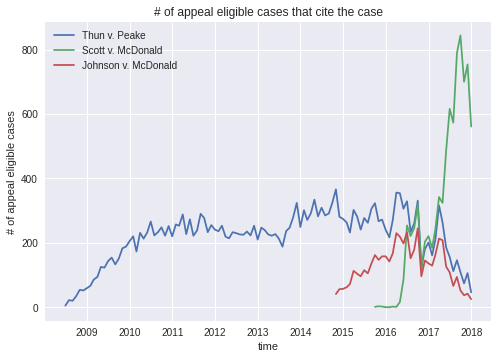

In [0]:
# plot for cite count
plt.style.use('seaborn')

for citation in citation_set.keys():
    df = extract_single(cases_set.get(citation))
    if df.empty or citation == "Overall": continue
    appeal_rates = df.groupby(pd.Grouper(key='timestamp', freq='M')).appealed_CAVC.count()
    # appeal_rates = appeal_rates.rolling(2).mean()
    plt.plot(appeal_rates.index, appeal_rates.values, label=citation)

plt.title('# of appeal eligible cases that cite the case')
plt.xlabel('time')
plt.ylabel('# of appeal eligible cases')
plt.legend()

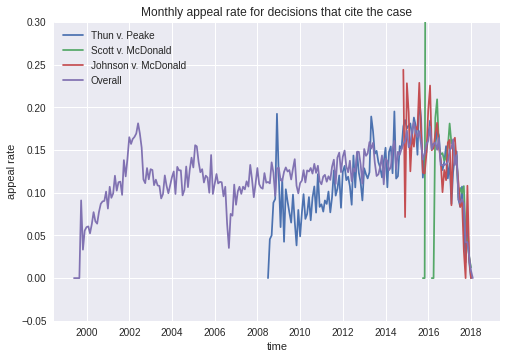

In [0]:
# plot for monthly appeal rate
for citation in citation_set.keys():
    df = extract_single(cases_set.get(citation))
    if df.empty: continue
    appeal_rates = df.groupby(pd.Grouper(key='timestamp', freq='M')).appealed_CAVC.mean()
    # appeal_rates = appeal_rates.rolling(2).mean()
    plt.plot(appeal_rates.index, appeal_rates.values, label=citation)

plt.title('Monthly appeal rate for decisions that cite the case')
plt.xlabel('time')
plt.ylabel('appeal rate')
plt.ylim(top=.3) # tweak for aesthetics
plt.legend()

In [0]:
# CAVC disposition codes and labels
disp_codes = ['Unfavorable', 'Favorable', 'Other']
disp_map = {
    '1': 'Unfavorable', 
    '5': 'Unfavorable', 
    '6': 'Favorable', 
    '7': 'Favorable', 
    '8': 'Favorable', 
    '9': 'Favorable', 
    '0': 'Other', 
    'D': 'Other', 
    'N': 'Other', 
    '2': 'Other',
}

In [0]:
# CAVC disposition distribution among all appealed cases that contain the citation
def plot_cavc_disposition_over_time(citation, code_to_plot='all'):
    # get only appealed cases
    cases = extract_single(cases_set.get(citation))
    appealed_cases = cases[cases.appealed_CAVC == 1].copy() # suppress SettingwithCopyWarning
    appealed_cases['cvdisp_mapped'] = appealed_cases.cvdisp.apply(lambda x: disp_map[x])

    # create disposition counts on a monthly basis for stack plots
    group_by_time = appealed_cases.groupby(pd.Grouper(key='timestamp', freq='M'))
    cvdisp_count = pd.DataFrame(0, index=group_by_time.groups.keys(), columns=disp_codes)
    for time, group in group_by_time:
        counts = group.cvdisp_mapped.value_counts(normalize=True)
        for code, count in counts.iteritems():
            cvdisp_count.loc[time, code] += count

    # plot all CAVC dispositions or only a specified one
    if code_to_plot != 'all':
        plt.plot(cvdisp_count.index, cvdisp_count[code_to_plot].values, label=citation)
        code_plotted = [label for label in disp_codes if label.startswith(code_to_plot)][0]
        plt.legend()
    else:
        plt.stackplot(cvdisp_count.index,
                    [ cvdisp_count[code].values for code in disp_codes ],
                    labels=disp_codes)
        code_plotted = "CAVC dispositions ({})".format(citation)
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.1, 0.5), loc="center")

    plt.xlabel('year')
    plt.ylabel('proportion')
    plt.title('Proportion of {} on a monthly basis'.format(code_plotted))

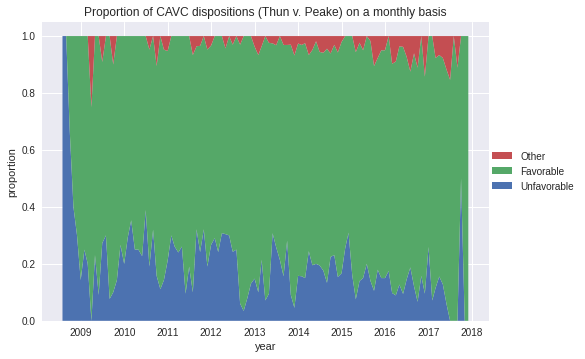

In [0]:
plot_cavc_disposition_over_time('Thun v. Peake')

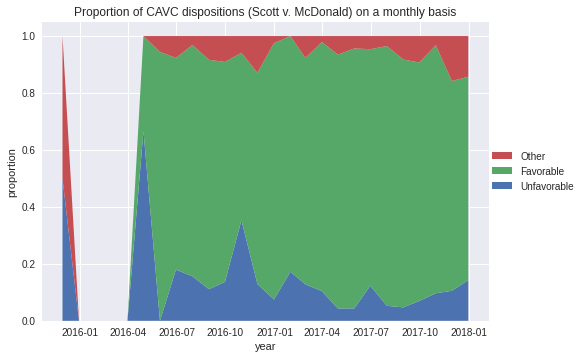

In [0]:
plot_cavc_disposition_over_time('Scott v. McDonald')

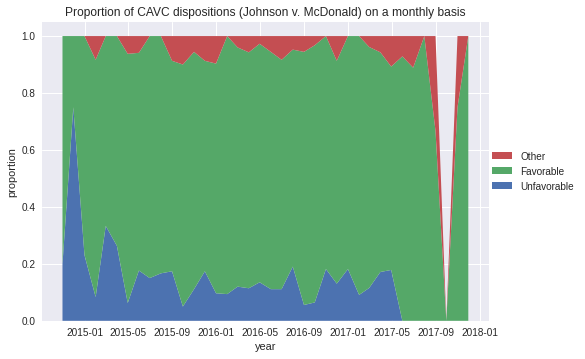

In [0]:
plot_cavc_disposition_over_time('Johnson v. McDonald')

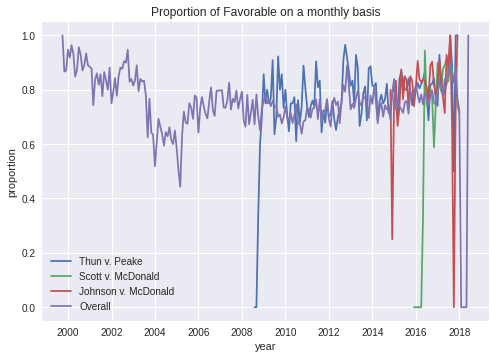

In [0]:
for citation in citation_set.keys():
    plot_cavc_disposition_over_time(citation, code_to_plot='Favorable')